In [28]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [18, 12]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import itertools

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

### Open Data File

In [98]:
## System Parameters
N       = 256
k0      = 1
alpha   = 2.0
beta    = 0.0 
iters   = 400000
m_end   = 8000
m_iters = 50
trans   = 10000
u0      = "RANDOM"


In [99]:
## Read open data file
results_dir    = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]".format(N, k0, alpha, beta, u0)
CLVfilename    = "/CLVData_ITERS[{},{},{}]_TRANS[{}]_LEs[{}]".format(iters, m_end, m_iters, trans, int(N/2 - k0))
SOLVERfilename = "/SolverData_ITERS[{}]_TRANS[{}]".format(iters, trans)

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/PhaseOrder"

print("\n\nCLV Data File: {}.h5\n".format(input_dir + results_dir + CLVfilename))
print("\n\nSolver Data File: {}.h5\n".format(input_dir + results_dir + SOLVERfilename))
HDFfileData_CLV = h5py.File(input_dir + results_dir + CLVfilename + '.h5', 'r')
HDFfileData_SOL = h5py.File(input_dir + results_dir + SOLVERfilename + '.h5', 'r')



CLV Data File: /work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/RESULTS_N[256]_k0[1]_ALPHA[2.000]_BETA[0.000]_u0[RANDOM]/CLVData_ITERS[400000,8000,50]_TRANS[10000]_LEs[127].h5



Solver Data File: /work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/RESULTS_N[256]_k0[1]_ALPHA[2.000]_BETA[0.000]_u0[RANDOM]/SolverData_ITERS[400000]_TRANS[10000].h5



### Compare R_k's

In [100]:
CLV_R_k = HDFfileData_CLV['R_k'][:]
SOL_order = HDFfileData_SOL['ThetaTimeScaleOrderParam'][-1, :]
SOL_R_k = np.absolute(SOL_order)

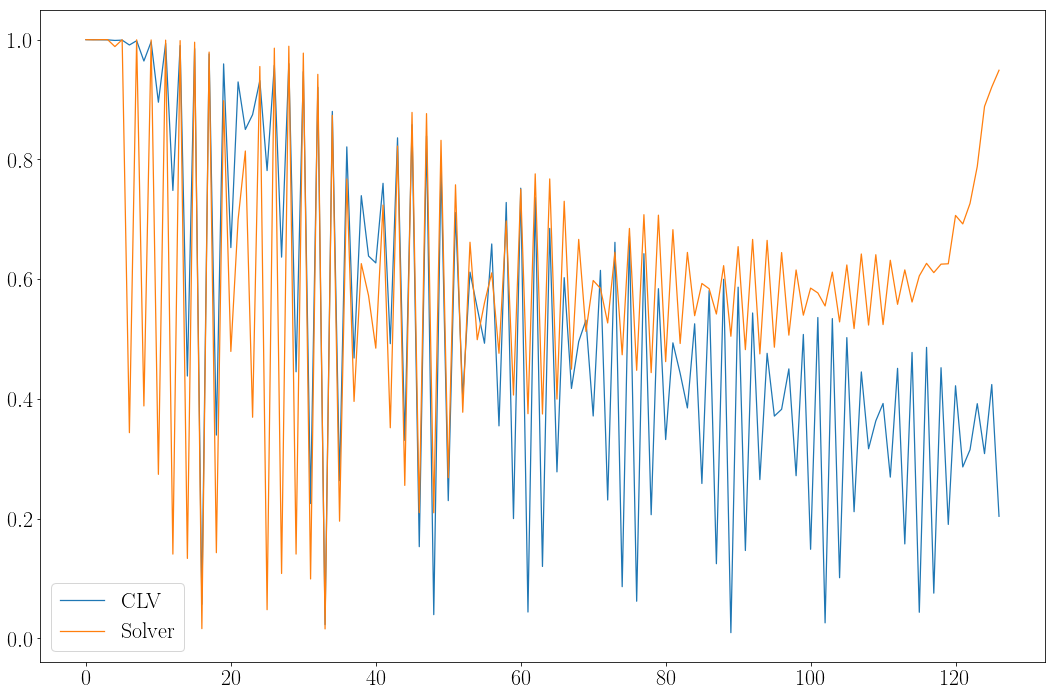

In [101]:
plt.figure()
plt.plot(CLV_R_k[k0 +1:])
plt.plot(SOL_R_k[k0 + 1:])
plt.legend([r"CLV", r"Solver"])

plt.show()

### Plot R_k over Squared Time-average CLV

In [102]:
CLV_R_k     = HDFfileData_CLV['R_k'][:]
MaxCLVStats = HDFfileData_CLV['MaxCLVStats'][:]
CLVsStats   = HDFfileData_CLV['CLVsStats'][:, :]

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


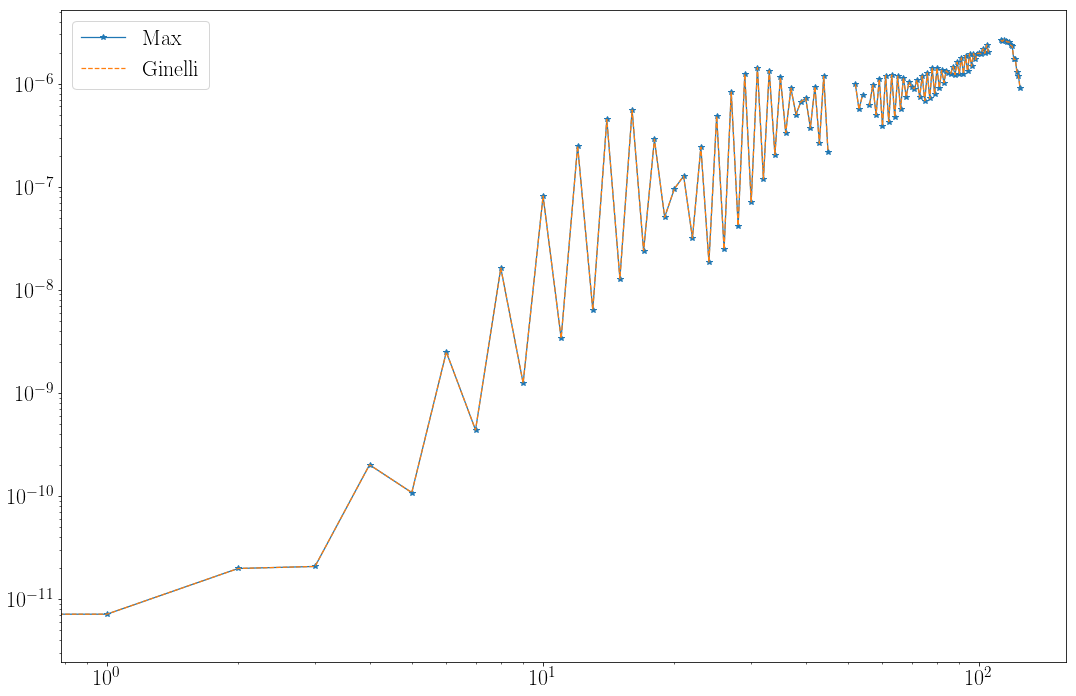

In [103]:
plt.figure()
plt.plot(MaxCLVStats[k0 + 1: ], '*-')
plt.plot(CLVsStats[0, k0 + 1: ], '--')
plt.legend([r"Max", r"Ginelli"])
plt.xscale('log')
plt.yscale('log')
plt.show()
# print(MaxCLVStats[k0 + 1: ])

In [104]:
amps = HDFfileData_CLV['Amps'][:]
dof = int(N/2 - k0)
clv  = HDFfileData_CLV['CLVs'][:, :]
num_clv_steps = clv.shape[0]
clvs = np.reshape(clv, (clv.shape[0], dof, dof))

v_k, v_k_proj, p_k = compute_clv_stats_data(clvs, amps, num_clv_steps, dof, int(N / 2 - k0))

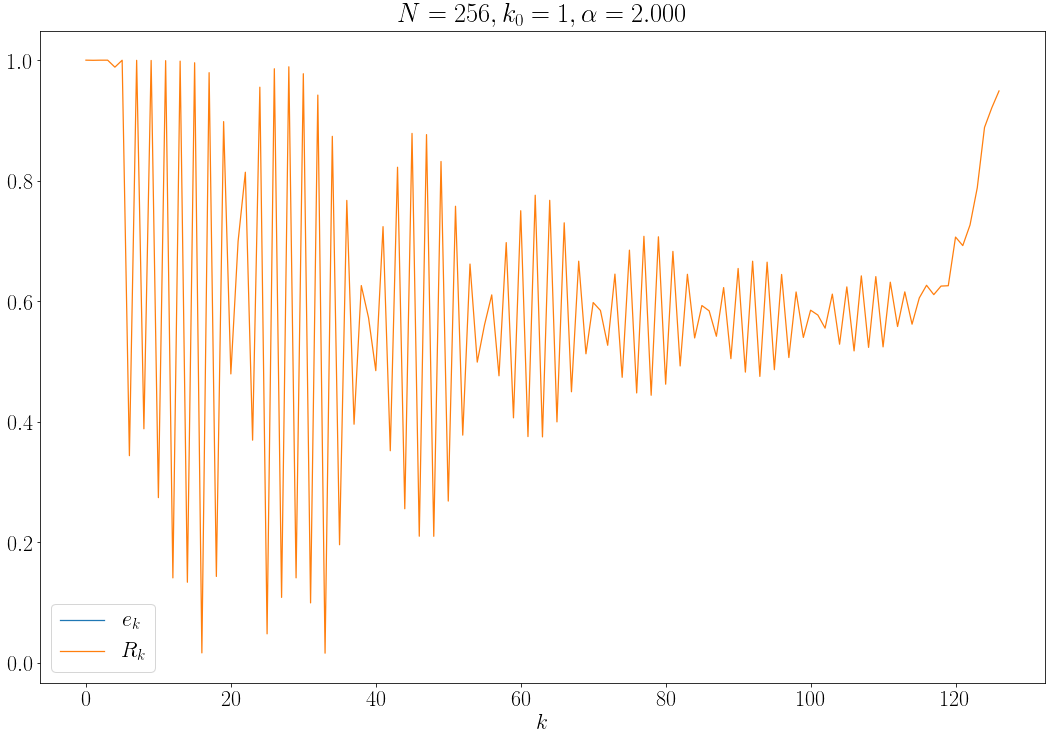

In [105]:
plt.figure()
plt.plot(np.absolute(MaxCLVStats[:] - np.mean(MaxCLVStats[:]))* 10**6)
plt.plot(SOL_R_k[k0 + 1: ])
plt.legend([r"$e_k$", r"$R_k$"])
plt.title(r"$N = {}, k_0 = {}, \alpha = {:0.3f}$".format(N, k0, alpha))
plt.xlabel(r"$k$")
plt.show()

In [106]:
@njit
def compute_clv_stats_data(clv, a_k, num_tsteps, dof, numLEs):
    
    ## Memory Allocation
    v_k      = np.zeros((dof, dof))
    p_k      = np.zeros((dof, dof))
    v_k_proj = np.zeros((dof, dof))

    ## Translation Invariant Direction -> T
    T           = np.arange(2.0, float(dof + 2), 1.0)
    T_a_k       = T * a_k[2:]
    T_norm_sqr  = np.linalg.norm(T) ** 2
    T_enorm_sqr = np.linalg.norm(T_a_k) ** 2
    
    ## Loop over time
    for t in range(num_tsteps):

        ## Loop over vectors
        for j in range(numLEs):
            
            ## Square each component
            v_k[:, j] += np.square(clv[t, :, j])

            ## Compute the projection
            v_proj  = clv[t, :, j] - (T * (np.dot(clv[t, :, j], T))) / T_norm_sqr
            clv_a_k = clv[t, :, j] * a_k[2:]
            v_enorm = clv_a_k - (T_a_k * np.dot(clv_a_k, T_a_k)) / T_enorm_sqr
            
            ## Renormalize after projection
            v_proj  = v_proj / np.linalg.norm(v_proj)
            v_enorm = v_enorm / np.linalg.norm(v_enorm)
            
            ## Update running sum
            p_k[:, j]      += np.square(v_enorm)
            v_k_proj[:, j] += np.square(v_proj)
            
    ## Compute averages
    v_k      = v_k / num_tsteps
    p_k      = p_k / num_tsteps
    v_k_proj = v_k_proj / num_tsteps
    

    return v_k, v_k_proj, p_k